In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
import h5py
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import maxflow
from PIL import Image, ImageOps
from scipy.spatial import KDTree
import lifelines
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [29]:
tcga_rep_data = pd.read_csv('./stad_tcga_pan_can_atlas_2018_clinical_data.tsv',delimiter= "\t")
tcga_rep_data.head()

,Study ID,Patient ID,Sample ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,Cancer Type Detailed,...,Subtype,Tumor Break Load,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tissue Source Site,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight
0,stad_tcga_pan_can_atlas_2018,TCGA-3M-AB46,TCGA-3M-AB46-01,70.0,STAGE IB,6TH,11.0,Esophagogastric Cancer,STAD,Stomach Adenocarcinoma,...,STAD_CIN,110.0,No,Yes,University of Kansas Medical Center,3M,5.600000,Stomach,Stomach Adenocarcinoma (NOS),NaN
1,stad_tcga_pan_can_atlas_2018,TCGA-3M-AB47,TCGA-3M-AB47-01,51.0,STAGE IIIB,6TH,6.0,Esophagogastric Cancer,STAD,Stomach Adenocarcinoma,...,STAD_GS,30.0,No,Yes,University of Kansas Medical Center,3M,3.566667,Stomach,Stomach Adenocarcinoma (NOS),NaN
2,stad_tcga_pan_can_atlas_2018,TCGA-B7-5816,TCGA-B7-5816-01,51.0,STAGE IIB,7TH,2.0,Esophagogastric Cancer,STAD,Diffuse Type Stomach Adenocarcinoma,...,STAD_MSI,48.0,No,Yes,Cureline,B7,40.100000,Stomach,"Stomach Adenocarcinoma, Diffuse Type",NaN
3,stad_tcga_pan_can_atlas_2018,TCGA-B7-5818,TCGA-B7-5818-01,62.0,STAGE IB,7TH,9.0,Esophagogastric Cancer,STAD,Diffuse Type Stomach Adenocarcinoma,...,STAD_EBV,41.0,No,Yes,Cureline,B7,11.500000,Stomach,"Stomach Adenocarcinoma, Diffuse Type",NaN
4,stad_tcga_pan_can_atlas_2018,TCGA-B7-A5TI,TCGA-B7-A5TI-01,52.0,STAGE IIIC,7TH,4.0,Esophagogastric Cancer,STAD,Diffuse Type Stomach Adenocarcinoma,...,STAD_MSI,87.0,Yes,No,Cureline,B7,18.433333,Stomach,"Stomach Adenocarcinoma, Diffuse Type",NaN


In [30]:
raw_prog_data = pd.read_excel('./TCGA-CDR-SupplementalTableS1.xlsx',sheet_name="ExtraEndpoints")
raw_prog_data

,Unnamed: 0,bcr_patient_barcode,type,PFI.1,PFI.time.1,PFI.2,PFI.time.2,PFS,PFS.time,DSS_cr,DSS.time.cr,DFI.cr,DFI.time.cr,PFI.cr,PFI.time.cr,PFI.1.cr,PFI.time.1.cr,PFI.2.cr,PFI.time.2.cr
0,1,TCGA-OR-A5J1,ACC,1.0,754.0,1.0,754.0,1.0,754.0,1.0,1355.0,1.0,754.0,1.0,754.0,1.0,754.0,1.0,754.0
1,2,TCGA-OR-A5J2,ACC,1.0,289.0,1.0,289.0,1.0,289.0,1.0,1677.0,NaN,NaN,1.0,289.0,1.0,289.0,1.0,289.0
2,3,TCGA-OR-A5J3,ACC,1.0,53.0,1.0,53.0,1.0,53.0,0.0,2091.0,1.0,53.0,1.0,53.0,1.0,53.0,1.0,53.0
3,4,TCGA-OR-A5J4,ACC,1.0,126.0,1.0,126.0,1.0,126.0,1.0,423.0,NaN,NaN,1.0,126.0,1.0,126.0,1.0,126.0
4,5,TCGA-OR-A5J5,ACC,1.0,50.0,1.0,50.0,1.0,50.0,1.0,365.0,NaN,NaN,1.0,50.0,1.0,50.0,1.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11155,11156,TCGA-YZ-A980,UVM,0.0,1862.0,0.0,1862.0,1.0,1556.0,0.0,1862.0,NaN,NaN,1.0,1556.0,0.0,1862.0,0.0,1862.0
11156,11157,TCGA-YZ-A982,UVM,0.0,495.0,0.0,495.0,0.0,495.0,0.0,495.0,NaN,NaN,0.0,495.0,0.0,495.0,0.0,495.0
11157,11158,TCGA-YZ-A983,UVM,0.0,798.0,0.0,798.0,0.0,798.0,0.0,798.0,NaN,NaN,0.0,798.0,0.0,798.0,0.0,798.0
11158,11159,TCGA-YZ-A984,UVM,0.0,1396.0,0.0,1396.0,1.0,154.0,1.0,1396.0,NaN,NaN,1.0,154.0,2.0,1396.0,2.0,1396.0


In [31]:
rep_prog_df = pd.merge(tcga_rep_data, raw_prog_data, left_on='Patient ID', right_on='bcr_patient_barcode', how='inner')


In [32]:
rep_prog_df.columns

Index(['Study ID', 'Patient ID', 'Sample ID', 'Diagnosis Age',
       'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Publication Version Type',
       'Aneuploidy Score', 'Cancer Type',
       'TCGA PanCanAtlas Cancer Type Acronym', 'Cancer Type Detailed',
       'Last Communication Contact from Initial Pathologic Diagnosis Date',
       'Birth from Initial Pathologic Diagnosis Date',
       'Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value',
       'Disease Free (Months)', 'Disease Free Status',
       'Months of disease-specific survival',
       'Disease-specific Survival status', 'Ethnicity Category',
       'Form completion date', 'Fraction Genome Altered',
       'Genetic Ancestry Label', 'Neoplasm Histologic Grade',
       'Neoadjuvant Therapy Type Administered Prior To Resection Text',
       'ICD-10 Classification',
       'International Classification of Diseases for Oncology, Third Edition IC

/tmp/ipykernel_209047/2339051957.py:5: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  meta_data_numeric = pd.factorize(meta_data)[0]


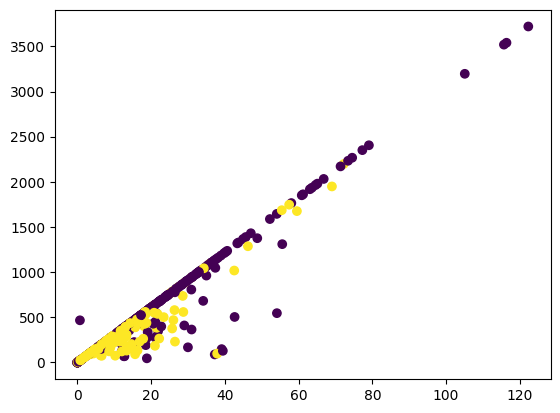

In [33]:
DSS_time = rep_prog_df["Overall Survival (Months)"].tolist()
PFI_time = rep_prog_df["PFI.time.cr"].tolist()
meta_data = rep_prog_df["American Joint Committee on Cancer Metastasis Stage Code"].tolist()
meta_data = rep_prog_df["Overall Survival Status"].tolist()
meta_data_numeric = pd.factorize(meta_data)[0]


plt.scatter(DSS_time, PFI_time,c=meta_data_numeric)

In [25]:
np.sum(np.array(rep_prog_df["PFS"].tolist())==1.0)

211